In [1]:
# import necessary libraries and read data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.metrics.functional import accuracy
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
# df = pd.read_csv('data/raw.csv').drop(columns='market_caps')

In [2]:
# splitting data at random into train/test sets, since we've fixed all the time-dependencies
class BTCData(pl.LightningDataModule):
    def __init__(self, filename, nrows=None, batch_size=256):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.filename = filename
        self.batch_size = batch_size
        self.nrows = nrows
        
    # load data from file
    def load_data(self):
        if self.nrows is not None:
            return np.load(self.filename)[:self.nrows]
        return np.load(self.filename)
    
    # create pytorch dataset from data
    def make_dataset(self, X, y):
        X = torch.Tensor(X)
        y = torch.Tensor(y).type(torch.float32)
        
        return TensorDataset(X, y)
        
    def setup(self, stage):
        # load dataset, split into X and y, relabel y to {0, 1}
        dataset = self.load_data()
        X = np.transpose(np.vstack(((dataset[:, 0], dataset[:, 4], dataset[:, 5]))))
        y = dataset[:, -1]
        y[y == -1] = 0
                
        # transform data
        X = self.scaler.fit_transform(X)
                
        # group data into sequences
        self.seq_len = 10
        full_len = len(X) - self.seq_len
        self.n_features = 3
        X_sequenced = np.zeros((full_len, self.seq_len, self.n_features))
        for i in range(full_len):
            X_sequenced[i] = X[i:i + self.seq_len]
        y = y[self.seq_len:]
            
        # split into train, validate, and test datasets
        test_size = 0.2
        val_size = 0.125
        X_train, X_test, y_train, y_test = train_test_split(X_sequenced, y, test_size=test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
        
        # create the datasets
        self.train = self.make_dataset(X_train, y_train)
        self.val = self.make_dataset(X_val, y_val)
        self.test = self.make_dataset(X_test, y_test)
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

In [3]:
# lightning module structure
class LSTM_Classifier(LightningModule):
    def __init__(self, n_features, hidden, layers, seq_len, classes):
        super().__init__()
        
        self.hidden = hidden
        self.seq_len = seq_len
        self.n_classes = classes
        self.n_layers = layers
        
        # lstm layer and linear hidden-state to classes layer
        # lstm inputs a batch of samples of shape (seq_len, n_features),
        #   outputs 1 hidden state of shape (seq_len, hidden_size)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, 
                            num_layers=layers, batch_first=True)
        # change the output to 1
        self.h2c = nn.Linear(hidden * seq_len, 1)
    
    def accuracy(self, y_hat, y):
        return (y_hat.round() == y).to(torch.float32).mean()
    
    # forward step - classification
    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        class_prob = self.h2c(lstm_out.reshape((-1, self.seq_len * self.hidden)))
        return torch.sigmoid(class_prob)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        train_loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', train_loss, logger=True)
        self.log('train_accuracy', acc, prog_bar=True, logger=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        val_loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', val_loss, logger=True, on_epoch=True)
        self.log('val_accuracy', acc, prog_bar=True, logger=True, on_epoch=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)
        
        test_loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        acc = self.accuracy(y_hat, y)
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        self.log('test_accuracy', acc, prog_bar=True, logger=True)
        return test_loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [91]:
pl.seed_everything(4622)

# feature params
n_features = 3
hidden = 5
layers = 2
seq_len = 10
classes = 1

# instantiate dataset, dataloader, model, and trainer
logger = CSVLogger("logs", name="lstm")
train_dl = BTCData('data/labeled_data.npy')
lstm_model = LSTM_Classifier(n_features, hidden, layers, seq_len, classes)
trainer = pl.Trainer(deterministic=True, logger=logger, gpus=int(torch.cuda.is_available()),
                    max_epochs=50, auto_scale_batch_size=False)
# trainer.tune(lstm_model, train_dl)

Global seed set to 4622
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [92]:
trainer.fit(lstm_model, train_dl)


  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 440   
1 | h2c  | Linear | 51    
--------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)


Epoch 0:  87%|██████ | 515/589 [00:09<00:01, 53.22it/s, loss=0.693, v_num=26, val_accuracy=0.494, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 1:  87%|██████ | 515/589 [00:10<00:01, 47.83it/s, loss=0.693, v_num=26, val_accuracy=0.497, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 2:  87%|██████ | 515/589 [00:09<00:01, 52.69it/s, loss=0.693, v_num=26, val_accuracy=0.497, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 3:  87%|██████ | 515/589 [00:09<00:01, 51.98it/s, loss=0.693, v_num=26, val_accuracy=0.497, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|██████ | 515/589 [00:10<00:01, 51.16it/s, loss=0.693, v_num=26, val_accuracy=0.497, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 5:  87%|██████ | 515/589 [00:10<00:01, 50.61it/s, loss=0.693, v_num=26, val_accuracy=0.497, train_accuracy=0.477]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|██████ | 515/589 [00:10<00:01, 51.07it/s, loss=0.693, v_num=26, val_accuracy=0.4

Epoch 18:  87%|█████▏| 515/589 [00:09<00:01, 53.25it/s, loss=0.693, v_num=26, val_accuracy=0.498, train_accuracy=0.479]
Validating: 0it [00:00, ?it/s]
Epoch 19:  87%|█████▏| 515/589 [00:09<00:01, 52.97it/s, loss=0.693, v_num=26, val_accuracy=0.498, train_accuracy=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 20:  87%|█████▏| 515/589 [00:09<00:01, 52.21it/s, loss=0.693, v_num=26, val_accuracy=0.498, train_accuracy=0.480]
Validating: 0it [00:00, ?it/s]
Epoch 21:  87%|█████▏| 515/589 [00:09<00:01, 52.09it/s, loss=0.693, v_num=26, val_accuracy=0.498, train_accuracy=0.484]
Validating: 0it [00:00, ?it/s]
Epoch 22:  87%|█████▏| 515/589 [00:09<00:01, 52.24it/s, loss=0.693, v_num=26, val_accuracy=0.498, train_accuracy=0.489]
Validating: 0it [00:00, ?it/s]
Epoch 23:  87%|█████▏| 515/589 [00:09<00:01, 51.74it/s, loss=0.693, v_num=26, val_accuracy=0.499, train_accuracy=0.494]
Validating: 0it [00:00, ?it/s]
Epoch 24:  87%|█████▏| 515/589 [00:09<00:01, 52.24it/s, loss=0.693, v_num=26, val_accuracy=0.5

Epoch 36:  87%|█████▏| 515/589 [00:09<00:01, 52.65it/s, loss=0.693, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 37:  87%|█████▏| 515/589 [00:09<00:01, 53.16it/s, loss=0.693, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 38:  87%|█████▏| 515/589 [00:09<00:01, 51.91it/s, loss=0.693, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 39:  87%|█████▏| 515/589 [00:09<00:01, 52.09it/s, loss=0.693, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 40:  87%|█████▏| 515/589 [00:10<00:01, 51.35it/s, loss=0.693, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 41:  87%|█████▏| 515/589 [00:10<00:01, 49.09it/s, loss=0.692, v_num=26, val_accuracy=0.500, train_accuracy=0.502]
Validating: 0it [00:00, ?it/s]
Epoch 42:  87%|█████▏| 515/589 [00:10<00:01, 47.55it/s, loss=0.692, v_num=26, val_accuracy=0.5

1

In [93]:
results = trainer.test()

Testing: 100%|██████████████████████████████████████████████████████████████████████| 147/147 [00:01<00:00, 128.84it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.4997815787792206, 'test_loss': 0.6915608644485474}
--------------------------------------------------------------------------------


In [94]:
# load in metrics from logger file
metrics = pd.read_csv(logger.experiment.metrics_file_path)

metrics.head()
df_train = metrics[['epoch', 'train_accuracy', 'train_loss']].dropna()
df_val = metrics[['epoch', 'val_accuracy', 'val_loss']].dropna()

test_acc = metrics['test_accuracy'].dropna().tolist()[0]
test_loss = metrics['test_loss'].dropna().tolist()[0]

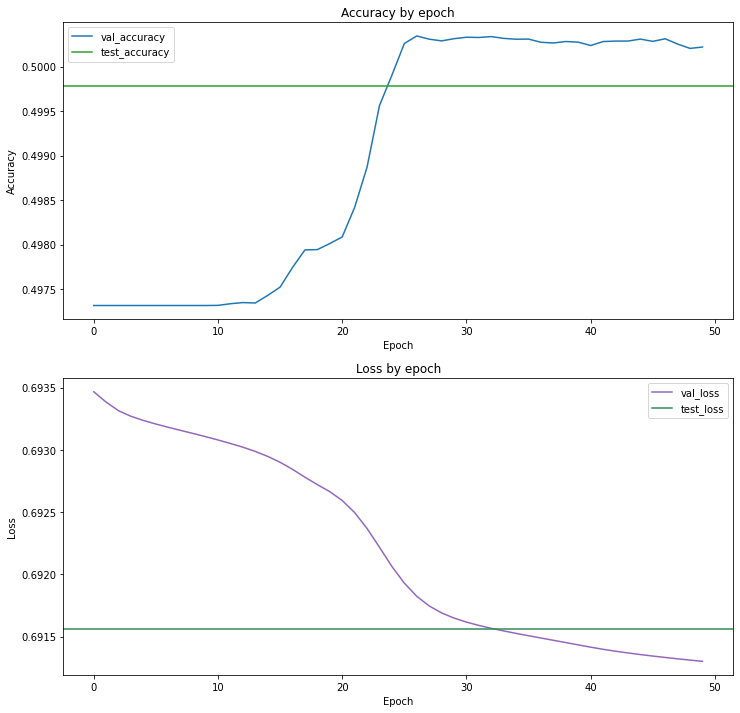

In [97]:
# plot
figs, axes = plt.subplots(nrows=2, figsize=(12, 12))

# accuracy
# axes[0].plot(df_train['epoch'], df_train['train_accuracy'], color='tab:red', label='train_accuracy')
axes[0].plot(df_val['epoch'], df_val['val_accuracy'], color='tab:blue', label='val_accuracy')
axes[0].axhline(test_acc, color='tab:green', label='test_accuracy')

# loss
# axes[1].plot(df_train['epoch'], df_train['train_loss'], color='tab:orange', label='train_loss')
axes[1].plot(df_val['epoch'], df_val['val_loss'], color='tab:purple', label='val_loss')
axes[1].axhline(test_loss, color='seagreen', label='test_loss')

# label, title, make pretty
titles = ['Accuracy by epoch', 'Loss by epoch']
dependent = ['Accuracy', 'Loss']
for i in range(2):
    axes[i].legend()
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(dependent[i])
plt.show()